In [10]:
# 전처리 작업 및 학습/테스트 데이터 구분 

import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler

class InputData():
    def __init__(self, filename):
        #read data and handle na's
        print("Processing input data...")
        # import data, drop leftmost col
        original = pd.read_csv(filename)
        original = original.drop(columns=['case_no'])
        # change pos->1, neg->0, na to NaN
        original = original.apply(lambda x: x.astype(str).str.strip())
        original['class'] = original['class'].replace(['pos', 'neg'], [1, 0])
        original = original.replace('na', np.NaN)
        # change back to float
        original = original.astype(np.float32)

        # histogram 여부를 기준으로 column 구분
        # 비슷한 이름을 가진 컬럼명들과 그렇지 않은 것들을 구분 
        attrs = original.columns[1:]
        attr_breakdown = {}
        non_histo = []
        histo = {}

        for a in attrs:
            a = a.split("_")
            try: attr_breakdown[a[0]].append(a[1])
            except KeyError: attr_breakdown[a[0]] = [a[1]]
        for attr, bins in attr_breakdown.items():
            if len(bins) == 1: non_histo.append(attr + "_" + bins[0])
            else: histo[attr] = bins

        # 1. histogram이 아닌 column processing : na는 neg와 pos의 mean으로
        for nh in non_histo:
            mask_pos = original['class'].eq(1) & original[nh].notna()
            mask_neg = original['class'].eq(0) & original[nh].notna()

            pos_mean = original.loc[mask_pos, nh].mean()
            neg_mean = original.loc[mask_neg, nh].mean()

            original[nh] = np.where(original['class'].eq(1) & original[nh].isna(), pos_mean, original[nh])
            original[nh] = np.where(original['class'].eq(0) & original[nh].isna(), neg_mean, original[nh])

        #https://kongdols-room.tistory.com/119
        # 2. histrogram columns processing :
        # na 처리 이전, row wise max, min, actvbin만 추출
        for a, bins in histo.items():
            full_bins = [a+"_"+b for b in bins]
            partial = original[['class']+full_bins]
            no_na = partial[partial.notna()]

            #aggregation of bins
            original[a+"_max"] = no_na.iloc[:, 1:].max(axis=1)
            original[a + "_min"] = no_na.iloc[:, 1:].where(no_na>0).min(axis=1)
            original[a + "_actv"] = no_na.iloc[:, 1:].where(no_na>0).count(axis=1)

            # na processing - na with pos
            attrwise_pos_max = original[a + "_max"].where(original['class'].eq(1)).mean(axis=0)
            attrwise_pos_min = original[a + "_min"].where(original['class'].eq(1)).mean(axis=0)
            attrwise_pos_actv = original[a + "_actv"].where(original['class'].eq(1)).mean(axis=0)

            original[a+"_max"] = np.where(original['class'].eq(1) & original[a+"_max"].isna(), attrwise_pos_max, original[a+"_max"])
            original[a+"_min"] = np.where(original['class'].eq(1) & original[a+"_min"].isna(), attrwise_pos_min, original[a+"_min"])
            original[a+"_actv"] = np.where(original['class'].eq(1) & original[a+"_actv"].eq(0), attrwise_pos_actv, original[a+"_actv"])

            # na processing - na with neg
            attrwise_neg_max = original[a + "_max"].where(original['class'].eq(0)).mean(axis=0)
            attrwise_neg_min = original[a + "_min"].where(original['class'].eq(0)).mean(axis=0)
            attrwise_neg_actv = original[a + "_actv"].where(original['class'].eq(0)).mean(axis=0)

            original[a + "_max"] = np.where(original['class'].eq(0) & original[a + "_max"].isna(), attrwise_neg_max, original[a + "_max"])
            original[a + "_min"] = np.where(original['class'].eq(0) & original[a + "_min"].isna(), attrwise_neg_min, original[a + "_min"])
            original[a + "_actv"] = np.where(original['class'].eq(0) & original[a + "_actv"].eq(0), attrwise_neg_actv, original[a + "_actv"])

            original = original.drop(columns=full_bins)

        #split feature and label
        self.feature = original.iloc[:, 1:]
        self.label =  original['class']

        #Standardization
        print("Standardizing data")
        std_scaler = StandardScaler()
        std_scaler.fit(self.feature)
        original_std = std_scaler.transform(self.feature)
        original_std = pd.DataFrame(original_std, columns=self.feature.columns, index=list(self.feature.index.values))
        self.feature = original_std

        print("Processing finished, saving file")
        file_name = "Train_data_processed_"+datetime.datetime.now().strftime('%Y%m%d_%H%M%S')+".csv"
        # self.processed.to_csv(file_name)
        print("Processed File Saved")

    def dataSplit(self, train_portion, val_portion, test_portion):
        # x = self.processed.iloc[:, 1:].to_numpy()
        # y = self.processed['class'].astype(int).to_numpy()

        x = self.feature.to_numpy()
        y = self.label.astype(int).to_numpy()

        shuffle_indices = np.random.permutation(np.arange(len(y)))  # [1,2,3,4...len] ->#[4509,11,1356,4...len]
        shuffled_x = x[shuffle_indices]  # input x를 shuffle 한 후 list를 numpy 자료형으로
        shuffled_y = y[shuffle_indices]  # output (정답) y를 shuffle
        train_index = int(train_portion * float(len(y)))
        test_index = -1 * int(test_portion * float(len(y)))
        self.x_train, self.x_val, self.x_test = shuffled_x[:train_index], shuffled_x[train_index+1:test_index], shuffled_x[test_index:]
        self.y_train, self.y_val, self.y_test = shuffled_y[:train_index], shuffled_y[train_index+1:test_index], shuffled_y[test_index:]

        self.y_train_one_hot = np.eye(2)[self.y_train]  # [9, 8, 0] -> [[0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 1, 0]
        # self.y_train_one_hot = np.squeeze(self.y_train_one_hot, axis=1)  # (45000, 10)
        self.y_val_one_hot = np.eye(2)[self.y_val]  # [9, 8, 0] -> [[0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 1, 0]
        # self.y_val_one_hot = np.squeeze(self.y_train_one_hot, axis=1)  # (45000, 10)
        self.y_test_one_hot = np.eye(2)[self.y_test]
        # self.y_test_one_hot = np.squeeze(self.y_test_one_hot, axis=1)
        return self.x_train, self.y_train_one_hot, self.x_val, self.y_val_one_hot, self.x_test, self.y_test_one_hot


Processing input data...
Standardizing data
Processing finished, saving file
Processed File Saved
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               12200     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_12 (Dense)             (None, 50)                2550      
______________________

54/54 [==============================] - 0s 1ms/step - loss: 0.0162 - accuracy: 0.9959 - recall: 0.9959 - precision: 0.9959
Accuracy = 1.00


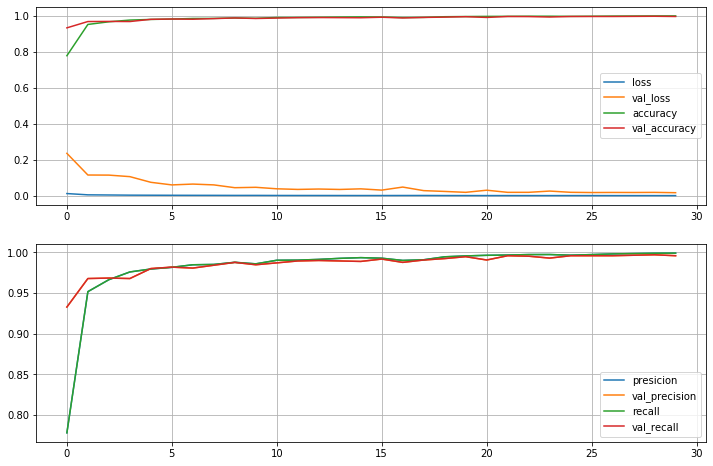

[[3891   16]
 [   2   81]]
1160
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3907
           1       0.84      0.98      0.90        83

    accuracy                           1.00      3990
   macro avg       0.92      0.99      0.95      3990
weighted avg       1.00      1.00      1.00      3990

20201005_003323.h5 saved


In [17]:
# 분석 모델 생성 후 결과 확인 후 모델 저장 

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import Adam
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import datetime

#model configuration setting
CLASS_WEIGHT = {0:0.015, 1:0.985}
LEARNING_RATE = 0.0001


#read csv file,
data = InputData("C:/Users/82106/Desktop/쿠빅/대회/Train_data/Train_data.csv")
x_train, y_train, x_val, y_val, x_test, y_test = data.dataSplit(0.9, 0.03, 0.07)

model = Sequential()
model.add(Dense(100,input_shape=(x_train.shape[1],),activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(50,activation='relu'))
# model.add(BatchNormalization(axis=1))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(LEARNING_RATE),
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.Precision(name='precision')])
model.summary()

class_weight = CLASS_WEIGHT
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size = 200, epochs=30, class_weight = class_weight)
loss, accuracy , recall, precision = model.evaluate(x_val, y_val)
print("Accuracy = {:.2f}".format(accuracy))

plt.figure(figsize=(12,8))
plt.subplot(2, 1, 1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy'])
plt.grid()
plt.subplot(2, 1, 2)

plt.plot(hist.history['precision'])
plt.plot(hist.history['val_precision'])
plt.plot(hist.history['recall'])
plt.plot(hist.history['val_recall'])
plt.legend(['presicion', 'val_precision', 'recall', 'val_recall'])
plt.grid()
plt.show()
# y_pred = model.predict(x_test)
# y_test_class = np.argmax(y_test,axis=1)
# y_pred_class = np.argmax(y_pred,axis=1)
#
# print(classification_report(y_test_class,y_pred_class))
# print(confusion_matrix(y_test_class,y_pred_class))

y_pred = model.predict(x_test)
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)
mat = confusion_matrix(y_test_class, y_pred_class)

co = mat[0, 1]*10 + mat[1,0]*500
print(mat)
print(co)
print(classification_report(y_test_class,y_pred_class))
#model.save(datetime.datetime.now().strftime('%Y%m%d_%H%M%S')+".h5")
print(datetime.datetime.now().strftime('%Y%m%d_%H%M%S')+".h5" + " saved")

In [15]:
# 저장한 모델 호출 후 실제 테스트 데이터 투입 시 사용될 모델 

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.models import load_model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix


MODEL_NAME = "20201001_234728"
LEARNING_RATE = 0.0001

# 생성된 모델이 있으므로 테스트 데이터 투입시 split 비율은 그대로 가져 오면 됨
data = InputData("C:/Users/82106/Desktop/쿠빅/대회/Train_data/Train_data.csv")
x_train, y_train, x_val, y_val, x_test, y_test = data.dataSplit(0, 0, 1.0)

#get saved model
model = load_model(MODEL_NAME+".h5")

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(LEARNING_RATE),
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.Precision(name='precision')])

#predict test data
y_pred = model.predict(x_test)
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)
mat = confusion_matrix(y_test_class, y_pred_class)

co = mat[0, 1]*10 + mat[1,0]*500
print(mat)
print(co)
print(classification_report(y_test_class,y_pred_class))

Processing input data...
Standardizing data
Processing finished, saving file
Processed File Saved
[[5575    7]
 [   0  118]]
70
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5582
           1       0.94      1.00      0.97       118

    accuracy                           1.00      5700
   macro avg       0.97      1.00      0.99      5700
weighted avg       1.00      1.00      1.00      5700

